<a href="https://colab.research.google.com/github/narutaku0914/KIKAGAKU/blob/master/kikagaku_ir1finetuning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ファインチューニング

ファインチューニング： 異なるDataSetで学習済みのモデルに関して一部または全部を再利用して新しいモデルを構築する<br>
手持ちのデータセットのサンプル数が少なくても性能が向上する場合も！

### 画像分類

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2

import tensorflow as tf

# GPUが使用可能か確認
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 4495340325163811180
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 9431672644072165897
physical_device_desc: "device: XLA_CPU device"
, name: "/device:XLA_GPU:0"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 10359954917484987458
physical_device_desc: "device: XLA_GPU device"
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 15701463552
locality {
  bus_id: 1
  links {
  }
}
incarnation: 2191762084586873608
physical_device_desc: "device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0"
]


データセットの準備

In [ ]:
# Data setの読み込み
train, test = tf.keras.datasets.cifar10.load_data()

# 画像の情報
train[0].shape, test[0].shape

170500096/170498071 [==============================] - 3s 0us/step


((50000, 32, 32, 3), (10000, 32, 32, 3))

In [ ]:
# ラベルの情報
train[1].shape, test[1].shape

((50000, 1), (10000, 1))

In [ ]:
# 学習用データとテスト用に対し正規化
x_tarin = train[0]/255
x_test = test[0]/255

# 目標値の切り分け
t_train = train[1]
t_test = test[1]

# 32bitにキャスト
x_train, x_test = x_tarin.astype('float32'), x_test.astype('float32')
t_train, t_test = t_train.astype('int32'), t_test.astype('int32')

モデルの定義

In [ ]:
import os, random


def reset_seed(seed=0):
  os.environ['PYTHONHASHSEED'] = '0'
  random.seed(seed)
  np.random.seed(seed)
  tf.random.set_seed(seed)

In [ ]:
from tensorflow.keras import models, layers

# シードの固定
reset_seed(0)

# モデルの構築
model = models.Sequential([
                           # 特徴量抽出
                           layers.Conv2D(filters=3, kernel_size=(3,3), activation='relu', input_shape=(32,32,3)),
                           layers.MaxPool2D(pool_size=(2,2)),
                           # ベクトル化
                           layers.Flatten(),
                           # 識別
                           layers.Dense(100, activation='relu'),
                           layers.Dense(10, activation='softmax')
])

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 30, 30, 3)         84        
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 15, 15, 3)         0         
_________________________________________________________________
flatten (Flatten)            (None, 675)               0         
_________________________________________________________________
dense (Dense)                (None, 100)               67600     
_________________________________________________________________
dense_1 (Dense)              (None, 10)                1010      
Total params: 68,694
Trainable params: 68,694
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# optimaizerの設定
optimizer = tf.keras.optimizers.Adam(lr=0.01)  # lr=learning rate

# モデルのコンパイル
model.compile(optimizer=optimizer,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

モデルの学習

In [ ]:
history = model.fit(x_tarin, t_train,
                    batch_size=4096,
                    epochs=30,
                    varldation_data=(x_test, t_test))

Epoch 1/30
13/13 [==============================] - 0s 22ms/step - loss: 2.1354 - accuracy: 0.2161
Epoch 2/30
13/13 [==============================] - 0s 19ms/step - loss: 1.8563 - accuracy: 0.3516
Epoch 3/30
13/13 [==============================] - 0s 20ms/step - loss: 1.6755 - accuracy: 0.4043
Epoch 4/30
13/13 [==============================] - 0s 20ms/step - loss: 1.5680 - accuracy: 0.4387
Epoch 5/30
13/13 [==============================] - 0s 20ms/step - loss: 1.4897 - accuracy: 0.4670
Epoch 6/30
13/13 [==============================] - 0s 19ms/step - loss: 1.4414 - accuracy: 0.4836
Epoch 7/30
13/13 [==============================] - 0s 19ms/step - loss: 1.3992 - accuracy: 0.5019
Epoch 8/30
13/13 [==============================] - 0s 19ms/step - loss: 1.3811 - accuracy: 0.5097
Epoch 9/30
13/13 [==============================] - 0s 19ms/step - loss: 1.3253 - accuracy: 0.5323
Epoch 10/30
13/13 [==============================] - 0s 20ms/step - loss: 1.2921 - accuracy: 0.5445
Epoch 11/

### ファインチューニング

注意点<br>
include_top = False で全結合層の除く<br>
weights='imagenet'で重み引き継げる

In [ ]:
from tensorflow.keras.applications import resnet, VGG16

# インスタンス化
base_model = VGG16(input_shape=(224,224,3),
                   include_top=False, weights='imagenet')

58892288/58889256 [==============================] - 0s 0us/step


In [ ]:
base_model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

全結合層抜いたため、maxpoolで終わっている

In [ ]:
# ランダムにデータを取得
# 学習用DataSet10000枚、テスト用５０００枚
train_choice = np.random.randint(low=0, high=50000, size=10000)
test_choice = np.random.randint(low=0, high=10000, size=5000)

In [ ]:
# データの準備
x_train = train[0][train_choice]
x_test = test[0][test_choice]
t_train = train[1][train_choice].astype('int32')
t_test = test[1][test_choice].astype('int32')

In [ ]:
_train, _test =[], []

# 画像サイズを224にリサイズして格納
# 画像の引数(src), dsize:リサイズ後のサイズ
for img in x_train:
  _train.append(cv2.resize(src=img, dsize=(224,224)))

for img in x_test:
  _test.append(cv2.resize(src=img, dsize=(224,224)))

# リストからndarrayに変換
x_train = np.array(_train, dtype='float32')/255.0
x_test = np.array(_test, dtype='float32')/255.0

x_train.shape, x_test.shape

((10000, 224, 224, 3), (5000, 224, 224, 3))

In [ ]:
reset_seed(0)

# モデルの定義
finetuned_model = models.Sequential([
                                     base_model,
                                     layers.GlobalAveragePooling2D(),
                                     layers.Dense(512, activation='relu'),
                                     layers.Dense(10, activation='softmax')
])

In [ ]:
optimizer = tf.keras.optimizers.SGD(lr=0.01)

# コンパイル
finetuned_model.compile(
    optimizer=optimizer,
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy'])

finetuned_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 7, 7, 512)         14714688  
_________________________________________________________________
global_average_pooling2d (Gl (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 512)               262656    
_________________________________________________________________
dense_3 (Dense)              (None, 10)                5130      
Total params: 14,982,474
Trainable params: 14,982,474
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# 学習
loss, accuracy = finetuned_model.evaluate(x_test, t_test)

157/157 [==============================] - 12s 79ms/step - loss: 2.4457 - accuracy: 0.0912


In [ ]:
print(f'loss: {loss}, accuracy:{accuracy}')

loss: 2.445748805999756, accuracy:0.09120000153779984


In [ ]:
history = finetuned_model.fit(x_train, t_train,
                    batch_size=32,
                    epochs=10,
                    validation_data=(x_test, t_test))

Epoch 1/10
313/313 [==============================] - 81s 258ms/step - loss: 2.0530 - accuracy: 0.2428 - val_loss: 1.8061 - val_accuracy: 0.3080
Epoch 2/10
313/313 [==============================] - 80s 255ms/step - loss: 1.4142 - accuracy: 0.5034 - val_loss: 0.9599 - val_accuracy: 0.7054
Epoch 3/10
313/313 [==============================] - 80s 255ms/step - loss: 0.9718 - accuracy: 0.6630 - val_loss: 0.9580 - val_accuracy: 0.6446
Epoch 4/10
313/313 [==============================] - 80s 255ms/step - loss: 0.7039 - accuracy: 0.7642 - val_loss: 0.6660 - val_accuracy: 0.7670
Epoch 5/10
313/313 [==============================] - 80s 255ms/step - loss: 0.5548 - accuracy: 0.8145 - val_loss: 1.0574 - val_accuracy: 0.6274
Epoch 6/10
313/313 [==============================] - 80s 255ms/step - loss: 0.4387 - accuracy: 0.8508 - val_loss: 0.4770 - val_accuracy: 0.8350
Epoch 7/10
313/313 [==============================] - 80s 255ms/step - loss: 0.3430 - accuracy: 0.8813 - val_loss: 0.5243 - val_ac

In [ ]:
# 予測精度の評価
results = pd.DataFrame(history.history)
results.tail(3)

,loss,accuracy,val_loss,val_accuracy
7,0.307820,0.8990,0.681062,0.7754
8,0.212423,0.9290,0.377259,0.8764
9,0.185537,0.9373,0.556018,0.8238


Text(0.5, 0, 'epochs')

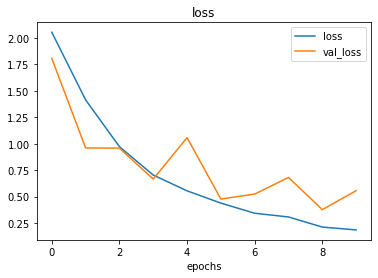

In [ ]:
# 損失の可視化
results[['loss', 'val_loss']].plot(title='loss')
plt.xlabel('epochs')

Text(0.5, 0, 'epochs')

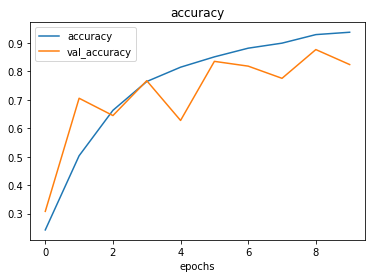

In [ ]:
# 正解率の可視化
results[['accuracy', 'val_accuracy']].plot(title='accuracy')
plt.xlabel('epochs')